In [2]:
import cv2 as cv
import cvzone
import sqlite3
import numpy as np
import json
import os # list directories
from datetime import datetime


In [3]:
# GETTING INFO FROM DATABASE
# DB CONNECTION
con = sqlite3.connect(
    'E:/OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkWeb-main\VisionParkWeb\VisionParkWeb\db.sqlite3', timeout=10)


def fetch_parkings(con)->list:
    cursorObj = con.cursor()
    cursorObj.execute('SELECT id,name FROM manageParking_parking')

    return cursorObj.fetchall()


def get_spaces(parking_id)->list:
    cursorObj = con.cursor()
    cursorObj.execute(
        f'SELECT id,vertex FROM manageParking_space WHERE parking_id={parking_id}')

    return cursorObj.fetchall() # [(5303, '[[854.5, 219.5], [809.5, 202.5], [845.5, 194.5], [890.5, 213.5]]'), ...]


def get_space_vacant(space_id)->bool:
    cursorObj = con.cursor()
    cursorObj.execute(
        f'SELECT vacant FROM manageParking_space WHERE id={space_id}')

    return cursorObj.fetchall()[0][0]

def update_space_occupancy(space_id, is_vacant):
    now = datetime.now()
    cursorObj = con.cursor()
    sql = f'UPDATE manageParking_space SET vacant="{1 if is_vacant else 0}", since=\"{now}\" WHERE id={space_id}'
    res = cursorObj.execute(sql)
    con.commit()
    
        

In [4]:
# CAR DETECTION IN ROI
def get_roi(img, vertex):
# https://stackoverflow.com/questions/15341538/numpy-opencv-2-how-do-i-crop-non-rectangular-region
    cols = vertex[:, :, 0].flatten()
    rows = vertex[:, :, 1].flatten()

    points = list(zip(cols, rows))
    row_min = min(rows)
    row_max = max(rows)
    col_min = min(cols)
    col_max = max(cols)

    # print(row_min, row_max, col_min, col_max)
    mask = np.zeros(img.shape, dtype=np.uint8)
    # fill the ROI so it doesn't get wiped out when the mask is applied
    cv.fillPoly(mask, [np.array(points)], 255)

    # apply the mask
    masked_image = cv.bitwise_and(img, mask)

    return masked_image[ row_min:row_max,col_min:col_max,]

def imhist(src):
    bgr_planes = cv.split(src)
    histSize = 256
    histRange = (0, 256)  # the upper boundary is exclusive
    accumulate = False
    b_hist = cv.calcHist(bgr_planes, [0], None, [
                         histSize], histRange, accumulate=accumulate)
    g_hist = cv.calcHist(bgr_planes, [1], None, [
                         histSize], histRange, accumulate=accumulate)
    r_hist = cv.calcHist(bgr_planes, [2], None, [
                         histSize], histRange, accumulate=accumulate)
    hist_w = 512
    hist_h = 400
    bin_w = int(round(hist_w/histSize))
    histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)
    cv.normalize(b_hist, b_hist, alpha=0, beta=hist_h,
                 norm_type=cv.NORM_MINMAX)
    cv.normalize(g_hist, g_hist, alpha=0, beta=hist_h,
                 norm_type=cv.NORM_MINMAX)
    cv.normalize(r_hist, r_hist, alpha=0, beta=hist_h,
                 norm_type=cv.NORM_MINMAX)
    for i in range(1, histSize):
        cv.line(histImage, (bin_w*(i-1), hist_h - int(b_hist[i-1])),
                (bin_w*(i), hist_h - int(b_hist[i])),
                (255, 0, 0), thickness=2)
        cv.line(histImage, (bin_w*(i-1), hist_h - int(g_hist[i-1])),
                (bin_w*(i), hist_h - int(g_hist[i])),
                (0, 255, 0), thickness=2)
        cv.line(histImage, (bin_w*(i-1), hist_h - int(r_hist[i-1])),
                (bin_w*(i), hist_h - int(r_hist[i])),
                (0, 0, 255), thickness=2)
    cv.imshow('Source image', src)
    cv.imshow('calcHist Demo', histImage)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
def imshow(img, title=''):
    while(1):
        cv.imshow(title, img)
        if cv.waitKey(20) & 0xFF == 27:
            break

def drawSpaceSeg(img, vertex, count, occupied, col_min, row_max, space_area, real_occupied=None):
    if real_occupied is not None:
        if not occupied and not real_occupied: # True positive
            cv.polylines(img, [vertex], True, (0, 255, 0), thickness=2)
        elif occupied and real_occupied: # True negative
            cv.polylines(img, [vertex], True, (0, 0, 255), thickness=2)
        elif occupied and not real_occupied: # False negative
             cv.polylines(img, [vertex], True, (58, 146, 255), thickness=2)
        else: # False positive
            cv.polylines(img, [vertex], True, (98, 169, 36), thickness=2)
    else:
        if not occupied:
            cv.polylines(img, [vertex], True, (0, 255, 0), thickness=2)
        else:
            cv.polylines(img, [vertex], True, (0, 0, 255), thickness=2)

    # Pixel count
    text = str(round(count/space_area,3))
    cvzone.putTextRect(img, text, (col_min, row_max-3), scale=0.8, thickness=1, offset=0)
    return img

def on_trackbar(a):
    pass    

def bwareaopen(imgOriginal, min_size, connectivity=8):
        """
        https://stackoverflow.com/questions/2348365/matlab-bwareaopen-equivalent-function-in-opencv
        Remove small objects from binary image (approximation of 
        bwareaopen in Matlab for 2D images).
    
        Args:
            img: a binary image (dtype=uint8) to remove small objects from
            min_size: minimum size (in pixels) for an object to remain in the image
            connectivity: Pixel connectivity; either 4 (connected via edges) or 8 (connected via edges and corners).
    
        Returns:
            the binary image with small objects removed
        """
        img = imgOriginal.copy()
        # Find all connected components (called here "labels")
        num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(
            img, connectivity=connectivity)
        
        # check size of all connected components (area in pixels)
        for i in range(num_labels):
            label_size = stats[i, cv.CC_STAT_AREA]
            
            # remove connected components smaller than min_size
            if label_size < min_size:
                img[labels == i] = 0
                
        return img

# https://stackoverflow.com/questions/451426/how-do-i-calculate-the-area-of-a-2d-polygon
def area(p):
    return 0.5 * abs(sum(x0*y1 - x1*y0
                         for ((x0, y0), (x1, y1)) in segments(p)))

def segments(p):
    return zip(p, p[1:] + [p[0]])

def is_space_vacant(vertex, count, k)->bool:
    a = area(vertex)

    return(count < k * a)

class DetectionParams:
    def __init__(self, gb_k, gb_s, at_method, at_blockSize, at_C, median_k=-1, bw_size=-1, bw_conn=8):
        self.gb_k = gb_k # GaussianBlur kernel
        self.gb_s = gb_s # GaussianBlur sigma (std. deviation)
        self.at_method = at_method # adaptiveThreshold method
        self.at_blockSize = at_blockSize # adaptiveThreshold blockSizeneighborhood that is used to calculate a threshold value for the pixel
        self.at_C = at_C # adaptiveThreshold C constant to be substracted
        self.median_k = median_k # Median filter kernel size (-1 if not desired to apply)
        self.bw_size = bw_size # bwareaopen remove objects smaller than this size (-1 if not desired to apply)
        self.bw_conn = bw_conn # bwareaopen neighborhood connectivity (default 8)

# params01 = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # 
params01 = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
#params01 = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 29, 16, 3, 25) # UFPR04

    
def preProcess(img, showImshow=False, params=params01):
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    imgBlur = cv.GaussianBlur(imgGray, params.gb_k, params.gb_s)

    imgThreshold = cv.adaptiveThreshold(imgBlur, 255, params.at_method, cv.THRESH_BINARY_INV, params.at_blockSize, params.at_C)
    #a,imgThreshold2 = cv.threshold(imgBlur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    # cv.imshow("IMGTresh", imgThreshold)

    # Remove salt and pepper noise
    if(params.median_k != -1):
        imgMedian = cv.medianBlur(imgThreshold, 3)
        if(showImshow):
            cv.imshow("IMGMedian", imgMedian)

    # Make thicker edges
    # kernel = np.ones((5,5), np.uint8) 
    # imgEro = cv.erode(imgMedian, kernel, iterations=1)
    # imgDilate = cv.dilate(imgEro, kernel, iterations=1)

    # Remove small objects
    if(params.bw_size != -1):
        imgBw = bwareaopen(imgMedian, 85)
        if(showImshow):
            cv.imshow("IMG", img)
            cv.imshow("imgBw", imgBw)
    # cv.imshow("IMG Dilate", imgDilate)             

    return imgBw

def setupPreprocess(img):
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    imgBlur = cv.GaussianBlur(imgGray, (5,5), 0)

    cv.namedWindow("Trackbars")
    cv.resizeWindow("Trackbars", 640, 240)
    cv.createTrackbar("Threshold Blocksize", "Trackbars", 25,100, on_trackbar)
    cv.createTrackbar("Threshold C", "Trackbars", 16,100, on_trackbar)
    cv.createTrackbar("Threshold BW", "Trackbars", 20,500, on_trackbar)

    while True:
        blocksize = cv.getTrackbarPos("Threshold Blocksize", "Trackbars")
        c = cv.getTrackbarPos("Threshold C", "Trackbars")
        if blocksize%2 == 0 or blocksize ==0:
            blocksize = blocksize+1
            
        imgThreshold = cv.adaptiveThreshold(imgBlur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, blocksize, c)
        #imgThreshold2 = cv.threshold(imgBlur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        imgMedian = cv.medianBlur(imgThreshold, 5)
        # imgEro = cv.erode(imgMedian, kernel, iterations=1)
        # imgDilate = cv.dilate(imgEro, kernel, iterations=1)

        bwThresh = cv.getTrackbarPos("Threshold BW", "Trackbars")
        imgBw = bwareaopen(imgThreshold, bwThresh)

        cv.imshow("IMG", img)
        cv.imshow("IMGTresh", imgThreshold)
        cv.imshow("IMGMedian", imgMedian)
        cv.imshow("IMG BW", imgBw)
        # cv.imshow("IMG Dilate", imgDilate)
    
    
        if cv.waitKey(1) == 27:         # wait for ESC key to exit and terminate progra,
            cv.destroyAllWindows()
            quit()
    

In [4]:
# SPACE DETECTION IN XML
import cv2 as cv
import numpy as np
from bs4 import BeautifulSoup # read XML
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.display import clear_output


def get_points_xml(space):
    vertex = []
    for p in space.contour.find_all('point'):
        vertex.append([p.get('x'), p.get('y')])
    return np.array(vertex, dtype=np.int32)

def detect_batch(files, params, showConfusionMatrix=True, showImshow=False):

    predicted = []
    real = []

    n_files = len(files)
    for idx, filename in enumerate(files):
        clear_output(wait=True)
        print(f"{idx+1}/{n_files}: ",filename)
        # SPACE OCCUPATION DETECTION 
        parking_img = cv.imread(filename)
        img = parking_img

        # setupPreprocess(img)
        imgPre = preProcess(img, showImshow, params)

        # Get spaces from xml
        with open( filename.replace('.jpg','.xml'), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        spaces = data.find_all('space')
                

        for space in spaces:
            vertex = get_points_xml(space)
            if(vertex.size==0): continue
            vertex = vertex.reshape(-1, 1, 2)

            cols = vertex[:, :, 0].flatten()
            rows = vertex[:, :, 1].flatten()
            points = list(zip(cols, rows))
            roi = get_roi(imgPre, vertex)
            
            # cv.imshow("roi", roi)

            # Count pixels with value '1'
            count = cv.countNonZero(roi)
            
            # drawSpaceSeg(img, vertex, count)
            vacant = is_space_vacant(points, count, params.k) # Depending on the detection area 

            vacant_real = space.get('occupied') == "0"
            predicted.append(vacant)
            real.append(vacant_real)

            if(showImshow):
                space_area = area(points)
                assert(space_area > 0)
                drawSpaceSeg(img, np.array(points, np.int32), count, not vacant, min(cols), max(rows), space_area, not vacant_real)
                if(vacant!=vacant_real): # Show error in prediction
                    print("ERROR PREDICTED vacant: "+str(bool(vacant)))
                    print("Pixel count: "+str(count))
                    print(f"Area: {space_area} k={count/space_area}")
                    print("---------------------------------")
                    cv.namedWindow("roi")
                    cv.destroyWindow("roi")
                    cv.imshow("roi", roi)
                    cv.imshow("IMG with space seg",img)
                    cv.waitKey()
            
        if(showImshow):
            cv.imshow("IMG with space seg",img)
            key = cv.waitKey()
            if(key==27):
                break


    if(showConfusionMatrix):
        confusion_matrix = metrics.confusion_matrix(real, predicted)

        #Precision Score = TP / (FP + TP). Minimize FP
        print('Precision: %.3f' % metrics.precision_score(real, predicted))
        #Recall Score = TP / (FN + TP). Minimize FN
        print('Recall: %.3f' % metrics.recall_score(real, predicted))
        #F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/) . Minimize FN over minimizing FP
        print('F1 Score: %.3f' % metrics.f1_score(real, predicted))
        #Accuracy Score = (TP + TN)/ (TP + FN + TN + FP) 
        print('Accuracy: %.3f' % metrics.accuracy_score(real, predicted))

        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Occupied', 'Vacant']) 
        cm_display.plot()
        plt.show()

    if(showImshow):
        cv.destroyAllWindows()

In [8]:
# SPACE OCCUPATION DETECTION 
# https://www.youtube.com/watch?v=caKnQlCMIYI
parkings = fetch_parkings(con)

for p in parkings :
    if p[1] == 'UFPR04':
        # SAMPLE STATIC PARKING CAPTURE
        parking_img = cv.imread(
            'E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkDetect\dataset/UFPR04_rainy.jpg')
        img = parking_img
        
        # setupPreprocess(img)
        imgPre = preProcess(img)
        
        parking_id = p[0]
        parking_name = p[1]

        print(f"Parking: {parking_id} - {parking_name}")

        spaces = get_spaces(parking_id)
                
        if len(spaces) > 0:
            for space in spaces:
                id = space[0]
                vertex = np.array(json.loads(space[1]), dtype=np.int32)
                vertex = vertex.reshape(-1, 1, 2)
                was_vacant = get_space_vacant(id) # Fetch de DB to get current space status
                #print(vertex)

                cols = vertex[:, :, 0].flatten()
                rows = vertex[:, :, 1].flatten()
                points = list(zip(cols, rows))
                
                roi = get_roi(imgPre, vertex)
                
                # cv.imshow("roi", roi)

                # Count pixels with value '1'
                count = cv.countNonZero(roi)
                
                # drawSpaceSeg(img, vertex, count)
                # cv.imshow("ROI", roi)
                k = 0.2
                vacant = is_space_vacant(points, count, k) # Depending on the detection area 
                if(vacant != was_vacant): # If status has changed
                    update_space_occupancy(id, vacant) # Update the space occupancy status
                    print("updated status")
                
                cv.imshow("IMG with space seg", drawSpaceSeg(img, np.array(points, np.int32), count, not vacant, min(cols), max(rows)), area(points))
                # cv.waitKey()
                # cv.destroyWindow("roi")

            cv.waitKey()

cv.destroyAllWindows()

Parking: 23 - UFPR04
updated status
updated status
updated status
updated status
updated status
updated status
updated status
updated status
updated status
updated status


In [9]:
# 
import cv2
import numpy as np
import argparse
drawing = False
ix,iy = -1,-1
img = cv2.imread(
            'E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkDetect\dataset/UFPR04_sample.jpg')

def mouse_event(event,x,y,flags,param):
    global ix,iy,drawing,mode
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y
    elif event == cv2.EVENT_LBUTTONUP:
        print(ix,iy)
       # print ix,iy
        drawing = False



cv2.namedWindow('image')
cv2.setMouseCallback('image',mouse_event)

while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)], title=''):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(12, 10))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    ax.set_title(title)
    


    # Plot pixel values with colors given in colors_rgb
    if pixels.ndim == 3:
        ax.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    elif pixels.ndim == 2:
        ax.scatter(
            pixels[:, 0].ravel(),
            pixels[:, 1].ravel(),
            pixels[:, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


In [ ]:
def imhist(img):

    bgr_planes = cv.split(img)
    histSize = 256
    histRange = (0, 256) # the upper boundary is exclusive
    accumulate = False
    b_hist = cv.calcHist(bgr_planes, [0], None, [histSize], histRange, accumulate=accumulate)
    g_hist = cv.calcHist(bgr_planes, [1], None, [histSize], histRange, accumulate=accumulate)
    r_hist = cv.calcHist(bgr_planes, [2], None, [histSize], histRange, accumulate=accumulate)
    hist_w = 512
    hist_h = 400
    bin_w = int(round( hist_w/histSize ))
    histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)
    cv.normalize(b_hist, b_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
    cv.normalize(g_hist, g_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
    cv.normalize(r_hist, r_hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
    for i in range(1, histSize):
        cv.line(histImage, ( bin_w*(i-1), hist_h - int(b_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(b_hist[i]) ),
                ( 255, 0, 0), thickness=2)
        cv.line(histImage, ( bin_w*(i-1), hist_h - int(g_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(g_hist[i]) ),
                ( 0, 255, 0), thickness=2)
        cv.line(histImage, ( bin_w*(i-1), hist_h - int(r_hist[i-1]) ),
                ( bin_w*(i), hist_h - int(r_hist[i]) ),
                ( 0, 0, 255), thickness=2)
    cv.imshow('Source image', img)
    cv.imshow('calcHist Demo', histImage)
    cv.waitKey()

In [ ]:
# DRAWING SPACES SEGMENTATION FOR EACH PARKING
parkings = fetch_parkings(con)

for p in parkings:

    # SAMPLE STATIC PARKING CAPTURE
    parking_img = cv.imread(
        'E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkWeb-main\VisionParkWeb\VisionParkWeb\VisionParkWeb\static\drawerJs\parking_sample.jpg')
    image = parking_img

    parking_id = p[0]
    parking_name = p[1]

    print(parking_id, "-", parking_name)

    spaces = get_spaces(parking_id)
    print(len(spaces), ' spaces')

    if len(spaces) > 0:
        for space in spaces:

            vertex = np.array(json.loads(space[1]), dtype=np.int32)
            vertex = vertex.reshape(-1, 1, 2)

            roi = get_roi(image, vertex)
            

            # Convert subsampled image to desired color space(s)
            img_small_RGB = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)  # OpenCV uses BGR, matplotlib likes RGB
            img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

            # Plot and show
            plot3d(img_small_RGB, img_small_rgb)
            plt.show()
            imshow(roi, 'roi')

            isClosed = True
            # Blue color in BGR
            color = (255, 0, 0)
            # Line thickness of 1 px
            thickness = 2

            # Using cv2.polylines() method
            # Draw a Blue polygon with thickness of 1 px
            # image = cv.polylines(image, [vertex], isClosed, color, thickness)

    # Show window
    # while(1):
    #     title = f'[{parking_id}] - {parking_name} - {len(spaces)} spaces'
    #     cv.imshow(title, image)
    #     if cv.waitKey(20) & 0xFF == 27:
    #         break

cv.destroyAllWindows()


In [ ]:
################################################################
#DATA EXTRACTION
################################################################
R = np.empty(1,np.uint8)
G = np.empty(1,np.uint8)
B = np.empty(1,np.uint8)

# https://newbedev.com/how-to-iterate-over-files-in-a-given-directory
directory = 'dataset\empty'
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        
        I = cv.imread(directory + '/' + filename)
        I = cv2.cvtColor(I, cv2.COLOR_BGR2HSV) 
    
        # Append pixel values per channel
        # imread uses BGR channels
        B = np.append(B, I[:,:,0])
        G = np.append(G, I[:,:,1])
        R = np.append(R, I[:,:,2])

# Take a sequence of 1-D arrays and stack them as columns to make a single 2-D array. 
RGB = np.column_stack((B, G, R))

mean = np.mean(RGB, axis = 0)
std = np.std(RGB, axis = 0)

# Plotting RGB values
rgb = RGB / 255.  # scaled to [0, 1], only for plotting
title = f"{np.size(RGB,0)} RGB samples\nMean: {mean}\nStd: {std}"
plot3d(RGB, rgb, title=title)
plt.show()
print(title)



# TODO: Saving to filename
# https://www.kite.com/python/answers/how-to-write-a-variable-to-a-file-in-python

        

In [ ]:
################################################################
#DATA EXTRACTION
################################################################
R = np.empty(1,np.uint8)
G = np.empty(1,np.uint8)
B = np.empty(1,np.uint8)

# https://newbedev.com/how-to-iterate-over-files-in-a-given-directory
directory = 'dataset\occupied'
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        
        I = cv.imread(directory + '/' + filename)
        I = cv.cvtColor(I, cv.COLOR_BGR2HSV) 
    
        # Append pixel values per channel
        # imread uses BGR channels
        B = np.append(B, I[:,:,0])
        G = np.append(G, I[:,:,1])
        R = np.append(R, I[:,:,2])

# Take a sequence of 1-D arrays and stack them as columns to make a single 2-D array. 
RGB = np.column_stack((B, G, R))

mean = np.mean(RGB, axis = 0)
std = np.std(RGB, axis = 0)

# Plotting RGB values
rgb = RGB / 255.  # scaled to [0, 1], only for plotting
title = f"{np.size(RGB,0)} RGB samples\nMean: {mean}\nStd: {std}"
plot3d(RGB, rgb, title=title)
plt.show()
print(title)



# TODO: Saving to filename
# https://www.kite.com/python/answers/how-to-write-a-variable-to-a-file-in-python

        

In [ ]:
import cv2 as cv
import sqlite3
import numpy as np
import json
import os # list directories

# SPACE OCCUPATION DETECTION 
# https://www.youtube.com/watch?v=caKnQlCMIYI
parkings = fetch_parkings(con)

for p, i in enumerate(parkings):

    # SAMPLE STATIC PARKING CAPTURE
    parking_img = cv.imread(
        'E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\VisionParkDetect\dataset/full.jpg')
    img = parking_img

    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    imgBlur = cv.GaussianBlur(imgGray, (3,3), 1)

    imgThreshold = cv.adaptiveThreshold(imgBlur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 25, 16)

    # Remove salt and pepper noise
    imgMedian = cv.medianBlur(imgThreshold, 5)

    # Make thicker edges
    kernel = np.ones((3,3), np.uint8) 
    imgDilate = cv.dilate(imgMedian, kernel, iterations=1)

    parking_id = p[0]
    parking_name = p[1]

    print(parking_id, "-", parking_name)

    spaces = get_spaces(parking_id)
    print(len(spaces), ' spaces')
            
    cv.imshow("IMG", img)
    cv.imshow("IMGTresh", imgThreshold)
    cv.imshow("IMGMedian", imgMedian)
    cv.imshow("IMG Dilate", imgDilate)
    
    cv.waitKey()

    if len(spaces) > 0:
        for space in spaces:

            vertex = np.array(json.loads(space[1]), dtype=np.int32)
            vertex = vertex.reshape(-1, 1, 2)

            roi = get_roi(imgMedian, vertex)

            # Count pixels with value '1'
            count = cv.countNonZero(roi)
            

            cv.imshow("ROI", roi)
            cv.imshow("IMG with space seg", drawSpaceSeg(img, vertex, count))
            cv.waitKey()


cv.destroyAllWindows()

55/56:  E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\UFPR05\Rainy\2013-04-13\2013-04-13_07_00_01.jpg
Precision: 0.781
Recall: 0.825
Accuracy: 0.802
Accuracy: 0.840


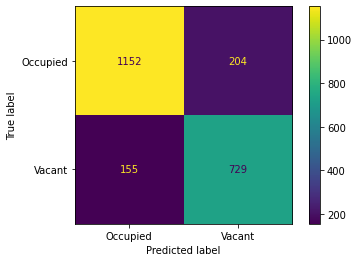

In [28]:
import random
import glob

path = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\\UFPR05\\Rainy'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/4))    # Select n random images from dataset

detect_batch(selected_files)

249/250:  E:\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\UFPR05\Sunny\2013-03-22\2013-03-22_08_25_02.jpg
Precision: 0.844
Recall: 0.799
Accuracy: 0.821
Accuracy: 0.849


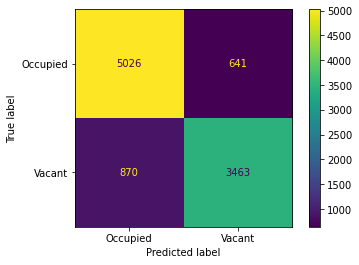

In [32]:
import random
import glob

path = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\TFG\PKLot\PKLot\PKLot\\UFPR05\\Sunny'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files)

207/207:  E:\Documents\PKLot\PKLot\PKLot\PKLot\UFPR05\Sunny\2013-02-24\2013-02-24_12_55_07.jpg
Precision: 0.802
Recall: 0.852
F1 Score: 0.826
Accuracy: 0.851


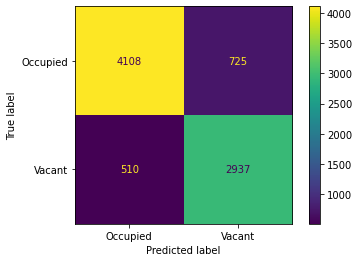

In [7]:
import random
import glob

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR05'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/20))    # Select n random images from dataset

detect_batch(selected_files, showImshow=False)
# BW area open

In [5]:
from ipynb.fs.full.detector import *
import random
import glob
#params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR
#params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 29, 10, 3, 25) # UFPR04

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR04'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files, params, showImshow=True)
#UPR04

2/379:  E:\Documents\PKLot\PKLot\PKLot\PKLot\UFPR04\Cloudy\2013-01-22\2013-01-22_14_35_09.jpg
ERROR PREDICTED vacant: True
Pixel count: 1608
Area: 9103.5 k=0.17663536002636349
---------------------------------
ERROR PREDICTED vacant: True
Pixel count: 1051
Area: 3694.0 k=0.28451543042772065
---------------------------------
ERROR PREDICTED vacant: True
Pixel count: 505
Area: 2189.0 k=0.23069894929191412
---------------------------------
ERROR PREDICTED vacant: True
Pixel count: 2531
Area: 13221.0 k=0.19143786400423568
---------------------------------
ERROR PREDICTED vacant: True
Pixel count: 715
Area: 2859.0 k=0.25008744316194476
---------------------------------
ERROR PREDICTED vacant: True
Pixel count: 839
Area: 3121.0 k=0.26882409484139697
---------------------------------
ERROR PREDICTED vacant: True
Pixel count: 451
Area: 1733.5 k=0.2601672916065763
---------------------------------
ERROR PREDICTED vacant: True
Pixel count: 1223
Area: 5594.0 k=0.2186271004647837
-----------------

447/447:  E:\Documents\PKLot\PKLot\PKLot\PKLot\PUCPR\Sunny\2012-09-18\2012-09-18_06_49_49.jpg
Precision: 0.886
Recall: 0.959
F1 Score: 0.921
Accuracy: 0.912


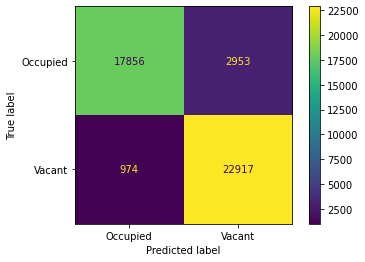

In [27]:
import random
import glob
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR
#params01 = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
#params01 = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 29, 16, 3, 25) # UFPR04

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\PUCPR'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files, params, showImshow=False)
#PUCPR

415/415:  E:\Documents\PKLot\PKLot\PKLot\PKLot\UFPR05\Cloudy\2013-04-13\2013-04-13_14_25_09.jpg
Precision: 0.808
Recall: 0.862
F1 Score: 0.834
Accuracy: 0.856


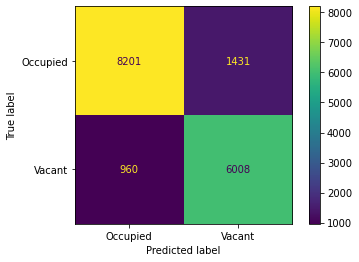

: 

In [29]:
import random
import glob
#params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
#params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 29, 16, 3, 25) # UFPR04

path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR05'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

detect_batch(selected_files, params, showImshow=False)
#UPR05